<a href="https://colab.research.google.com/github/marriamaslova/compling_nlp_hse_course/blob/master/notebooks/word_embeddings/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

In [ ]:
!pip install matplotlib pandas

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [ ]:
!pip install razdel

In [ ]:
from razdel import tokenize as razdel_tokenize

In [ ]:
!pip install pymorphy2
!pip install -U pymorphy2-dicts-ru

In [ ]:
import pymorphy2
pm = pymorphy2.MorphAnalyzer()

In [ ]:
!pip install pymystem3==0.1.10

In [ ]:
from pymystem3 import Mystem
m = Mystem()

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window используется не так и вам нужно это  изменить!)  

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

Предобработка

In [ ]:
wiki = open('wiki_data.txt').read().split('\n')

In [ ]:
import re

In [ ]:
def preprocess_data(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    lemmas = []
    for elem in tokens:
      res = pm.parse(elem)[0].normal_form
      lemmas.append(res)
    return lemmas

In [ ]:
vocab = Counter()
for text in wiki:
  vocab.update(preprocess_data(text))

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
word2id = { 'PAD':0}
for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
sentences = []

for text in wiki:
    lemmas = preprocess_data(text)
    if not lemmas:
        continue
    ids = [word2id[lemma] for lemma in lemmas if lemma in word2id]
    sentences.append(ids)

Skip Gram

In [ ]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [ ]:
vocab_size = len(id2word)

In [ ]:
def gen_batches_sg(sentences, window = 12, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[i-window:i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [ ]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(gen_batches_sg(sentences[:19000], window=12),
          validation_data=gen_batches_sg(sentences[19000:],  window=12),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
10000/10000 [==============================] - 891s 89ms/step - loss: 0.4633 - accuracy: 0.7873 - val_loss: 0.5135 - val_accuracy: 0.7661
Epoch 2/2
10000/10000 [==============================] - 830s 83ms/step - loss: 0.4464 - accuracy: 0.8034 - val_loss: 0.5275 - val_accuracy: 0.7749


In [ ]:
embeddings_sg = model.layers[2].get_weights()[0]

In [ ]:
most_similar('семья', embeddings_sg)

['семья',
 'родиться',
 'губерния',
 'василий',
 'окончить',
 'деятель',
 'школа',
 'учиться',
 'младший',
 'иванович']

In [ ]:
most_similar('гора', embeddings_sg)

['гора',
 'река',
 'юг',
 'озеро',
 'долина',
 'протекать',
 'юго-западный',
 'бассейн',
 'запад',
 'километр']

In [ ]:
most_similar('футбол', embeddings_sg)

['футбол',
 'тренер',
 'чемпион',
 'сборная',
 'обыграть',
 'дважды',
 'лига',
 'сборный',
 'япония',
 'первенство']

Cbow

In [ ]:
def gen_batches_cbow(sentences, window = 6, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[i-window:i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [ ]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(gen_batches_cbow(sentences[:19000], window=6),
          validation_data=gen_batches_cbow(sentences[19000:],  window=6),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 [==============================] - 480s 96ms/step - loss: 0.3519 - accuracy: 0.8497 - val_loss: 0.2929 - val_accuracy: 0.8818
Epoch 2/2
5000/5000 [==============================] - 486s 97ms/step - loss: 0.2672 - accuracy: 0.8912 - val_loss: 0.2542 - val_accuracy: 0.8983


In [ ]:
embeddings_cb = model.layers[2].get_weights()[0]

In [ ]:
most_similar('семья', embeddings_cb)

['семья',
 'ребёнок',
 'жить',
 'отец',
 'крестьянин',
 'брат',
 'родитель',
 'дом',
 'родиться',
 'они']

In [ ]:
most_similar('река', embeddings_cb)

['река',
 'озеро',
 'берег',
 'гора',
 'холм',
 'ручей',
 'дунай',
 'равнина',
 'устье',
 'долина']

In [ ]:
most_similar('хоккей', embeddings_cb)

['хоккей',
 'гандбол',
 'волейбол',
 'мини-футбол',
 'теннис',
 'скелетон',
 'бобслей',
 'баскетбол',
 'юниорский',
 'дзюдо']

В целом полученные эмбеддинги кажутся довольно адекватными. Вот что точно можно сказать, что они отражают характер материала: можно просто посмотреть и уже догадаться, что данные взяты из Википедии

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [ ]:
!pip install gensim

In [ ]:
import gensim

In [ ]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [ ]:
texts = [preprocess(text) for text in wiki]

In [ ]:
%%time
w2v = gensim.models.Word2Vec(texts, size=500, min_count=10, max_vocab_size=9000, window=9, iter=6, hs=1, sg = 0, sample = 1e-5)

CPU times: user 30.8 s, sys: 340 ms, total: 31.1 s
Wall time: 20.7 s


In [ ]:
w2v.wv.most_similar('церковь')

[('храм', 0.9682762026786804),
 ('церкви', 0.9503377676010132),
 ('xvii', 0.8922445774078369),
 ('монастыря', 0.891191840171814),
 ('собор', 0.8865468502044678),
 ('монастырь', 0.8786105513572693),
 ('святого', 0.8784339427947998),
 ('xviii', 0.8723244071006775),
 ('здание', 0.8721140027046204),
 ('честь', 0.8578802347183228)]

In [ ]:
%%time
ft = gensim.models.FastText(texts, size=500, min_count=10, max_vocab_size=9000, window=9, iter=6, hs=1, sg = 0, sample = 1e-5, min_n=2, max_n=5)

CPU times: user 2min 53s, sys: 2.42 s, total: 2min 55s
Wall time: 1min 45s


In [ ]:
ft.wv.most_similar('церковь')

[('церкви', 0.9647018909454346),
 ('храм', 0.954418957233429),
 ('монастыря', 0.9057528376579285),
 ('монастырь', 0.9023568630218506),
 ('xviii', 0.8511088490486145),
 ('епархии', 0.8485535383224487),
 ('святой', 0.8473834991455078),
 ('xvii', 0.844466507434845),
 ('петра', 0.8240376710891724),
 ('святого', 0.8198497295379639)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [ ]:
data = pd.read_csv('labeled.csv')

In [ ]:
data['norm_text'] = data.comment.apply(preprocess)

In [ ]:
data['lemm_text'] = data.comment.apply(preprocess_data)

In [ ]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

In [ ]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [ ]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

Модели из первого задания 

Предобработка

In [ ]:
vocab_3 = Counter()
for elem in data['comment']:
  vocab_3.update(preprocess_data(elem))
for text in wiki:
  vocab_3.update(preprocess_data(text))

In [ ]:
filtered_vocab_3 = set()

for word in vocab_3:
    if vocab_3[word] > 30:
        filtered_vocab_3.add(word)

In [ ]:
word2id_3 = { 'PAD':0}
for word in filtered_vocab_3:
    word2id_3[word] = len(word2id_3)

In [ ]:
id2word_3 = {i:word for word, i in word2id_3.items()}

In [ ]:
sentences_3 = []

for elem in data['comment']:
    lemmas = preprocess_data(elem)
    if not lemmas:
        continue
    ids = [word2id_3[lemma] for lemma in lemmas if lemma in word2id_3]
    sentences_3.append(ids)
for text in wiki:
    lemmas = preprocess_data(text) 
    if not lemmas:
        continue
    ids = [word2id_3[lemma] for lemma in lemmas if lemma in word2id_3]
    sentences_3.append(ids)

Skip Gram

In [ ]:
vocab_size_3 = len(id2word_3)

In [ ]:
def gen_batches_sg_3(sentences_3, window = 12, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences_3:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[i-window:i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size_3))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [ ]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id_3), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id_3), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(gen_batches_sg_3(sentences_3[:19000], window=12),
          validation_data=gen_batches_sg_3(sentences_3[19000:],  window=12),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=2)

In [ ]:
embeddings_cb_3 = model.layers[2].get_weights()[0]

In [ ]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_3), output_dim=300, 
                                       trainable=False,
                                       weights=[embeddings_cb_3])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


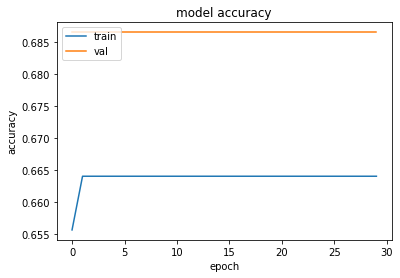

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

CBOW

In [ ]:
def gen_batches_cbow_3(sentences_3, window = 6, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences_3:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[i-window:i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size_3))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [ ]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id_3), output_dim=500)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id_3), output_dim=500)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(gen_batches_cbow_3(sentences_3[:19000], window=6),
          validation_data=gen_batches_cbow_3(sentences_3[19000:],  window=6),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

In [ ]:
embeddings_true_cb_3 = model.layers[2].get_weights()[0]

In [ ]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_3), output_dim=500, 
                                       trainable=False,
                                       weights=[embeddings_true_cb_3])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


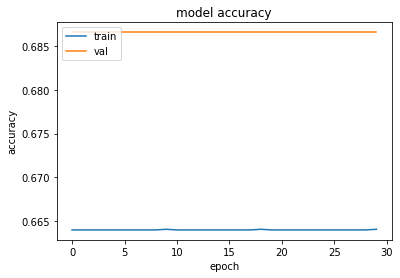

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Fastext Gensim (текстовые данные и данные для классификации не лемматизированы, а только токенизированы, согласно второму заданию)

In [ ]:
ft_3 = gensim.models.FastText(texts + data['norm_text'].values.tolist(), size=500, min_count=10, max_vocab_size=9000, window=9, iter=6, hs=1, sg = 0, sample = 1e-5, min_n=2, max_n=5)

In [ ]:
weights = np.zeros((len(word2id), 500))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = ft_3.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = ft_3.wv['опрагпллирао']

In [ ]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=500, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


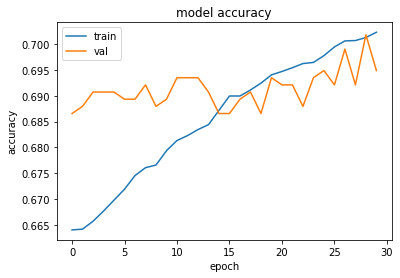

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Word2Vec Gensim

In [ ]:
w2v_3 = gensim.models.Word2Vec(texts + data['norm_text'].values.tolist(), size=500, min_count=10, max_vocab_size=9000, window=9, iter=6, hs=1, sg = 0, sample = 1e-5)

In [ ]:
weights = np.zeros((len(word2id), 500))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = w2v_3.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = w2v_3.wv['опрагпллирао']

In [ ]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=500, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


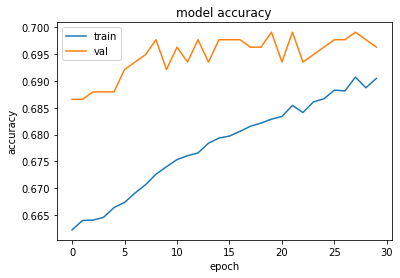

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Не уверена, что правильно интерпретирую получившиеся результаты, но мне кажется, что из представленных наборов эмбеддингов лучше всего себя показал Gensim Fastext 

Предобученная модель

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model_dwnl = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/ruscorpora_upos_skipgram_300_5_2018.vec', binary=False)

In [ ]:
mapping = {}

for line in open('ru-rnc.map.txt'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [ ]:
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [ ]:
texts_ud = [normalize_mystem(text) for text in wiki]

In [ ]:
data['text_ud'] = data.comment.apply(normalize_mystem)

In [ ]:
vocab_3_ud = Counter()
for elem in data['comment']:
  vocab_3_ud.update(normalize_mystem(elem))
for text in wiki:
  vocab_3_ud.update(normalize_mystem(text))

In [ ]:
filtered_vocab_3_ud = set()

for word in vocab_3_ud:
    if vocab_3_ud[word] > 30:
        filtered_vocab_3_ud.add(word)

In [ ]:
word2id_3_ud = { 'PAD':0}
for word in filtered_vocab_3_ud:
    word2id_3_ud[word] = len(word2id_3_ud)

In [ ]:
weights = np.zeros((len(word2id_3_ud), 300))

for word, i in word2id_3_ud.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = model_dwnl.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = model_dwnl.wv['опрагпллирао']

In [ ]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_3_ud), output_dim=300, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


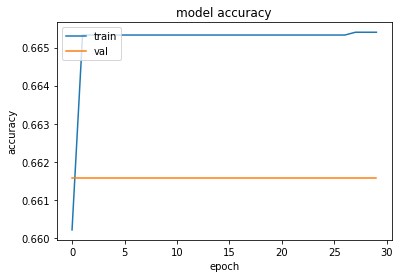

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()